# Botón Para Esconder Código

In [1]:
#Sacado de https://mljar.com/blog/jupyter-notebook-hide-code/
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Aprete aqui para visualizar/esconder bloques de codigo."></form>''')

## Libraries y Display

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import statistics

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Parte I: Análisis de la base de hogares y cálculo de pobreza

1)  Abrimos la base de datos de la EPH y nos quedamos con los observaciones de GBA.

In [3]:
#Abrimos la base
hogar = pd.read_excel('./EPH_usu_1er_Trim_2022_xlsx/usu_hogar_T122.xlsx')

#Eliminamos todos los aglomerados que no correspondan a CABA (cód 32) o GBA (cód 33)
hogar_cortado = hogar.query("AGLOMERADO in (32, 33)") # la manera mas rapida y facil de hacerlo


2) Unimos encuesta individual y encuesta hogar (en base a CODUDU y NRO HOGAR)

In [4]:
#Importamos tabla individual 
#Abrimos la base
individual = pd.read_excel('./EPH_usu_1er_Trim_2022_xlsx/usu_individual_T122.xlsx')

#Eliminamos todos los aglomerados que no correspondan a CABA (cód 32) o GBA (cód 33)
individual_cortado = individual.query("AGLOMERADO in (32, 33)") # la manera mas rapida y facil de hacerlo


In [5]:
#Mergeamos ambos DF
eph = individual_cortado.merge(hogar_cortado,how='left',on=['CODUSU', 'NRO_HOGAR'], suffixes=('', '_y'))

#notamos que hay columnas repetidas
eph['ITF'].equals(eph['ITF_y'])

#Borramos las que tengan sufijo  _y
eph.drop(eph.filter(regex='_y$').columns, axis=1, inplace=True)



<span style='background :yellow' > Está bien, otra forma de solucionar el tema de las repetidas es hacer lo siguiente:

In [6]:
# Definimos las intersección entre las dos bases como una lista
columnas_duplicadas = set(individual_cortado.columns).intersection(set(hogar_cortado.columns))
# Removemos CODUSU y NRO_HOGAR de la lista ya que queremos usarlas para la intersección (y las columnas sobre las que se une
# no generan duplicados)
columnas_duplicadas.remove("CODUSU")
columnas_duplicadas.remove("NRO_HOGAR")

# Hacemos el merge habiendo dropeado las columnas repetidas
eph = pd.merge(
    individual_cortado.drop(columnas_duplicadas, axis=1), 
    hogar_cortado,
    on= ['NRO_HOGAR', 'CODUSU']
)

3) 
- A continuación, listamos las funciones y procediientos que usamos para limpiar la base:

- Para eliminar aquellas observaciones relacionadas a ingreso que sea negativo, utilizaremos el metodo .loc, combinando con el prefijo ~ para expresar que queremos localizar aquellas que no sean negativas en algun punto.
-  Eliminamos duplicados con .drop_duplicates
- Con .isnull, .dropna y .shape eliminamos aquellas columnas que tengan mas de un porcentaje de NAs.
- Armando un interquantile range score eliminamos outliers que en cierto rango.
- Para Boxplots, seaborn y matplotlib.
- Con .dtypes nos fijamos el tipo de las variables restantes.
- Categoricas reemplazamos NaN por metodos .fillna, .isnull, .add_categories.
- Continuas relacionadas a ingreso con NAs, asumimos que la no respuesta es un 0 en caso de que no venga ya asi la base.
- Eliminaremos outliers utilizando interquantile range scores para detectarlos y eliminarlos.


In [7]:
#Eliminamos aquellas que tengan ingreso o edad negativa
eph = eph.loc[~(
(eph['CH06']<0) | 
(eph['PP08D1']<0) | 
(eph['PP08D4']<0) |
(eph['PP08F1']<0) |
(eph['PP08F2']<0) |
(eph['PP08J1']<0) |
(eph['PP08J2']<0) |
(eph['PP08J3']<0) |
(eph['ITF']<0) |
(eph['IPCF']<0) )]

In [8]:
#Chequeamos si hay duplicados y los dropeamos
eph = eph.drop_duplicates()
#no hay duplicados, cool!

In [9]:
#Cheque columnas con muchos NAs, si tiene mas de 70% los vamos a  borrar 
#Notese quiebre de NAs en 96% y 81%, no es tan arbitrario el 70%
percent_missing = eph.isnull().sum() * 100 / len(eph)
missing_value_eph = pd.DataFrame({'Columna': eph.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph.sort_values('Porcentaje de NAs', inplace=True,ascending=False)


In [10]:
#Borramos mas de 80%
perc = 70.0
min_count =  int(((100-perc)/100)*eph.shape[0] + 1)
eph = eph.dropna( axis=1, 
                thresh=min_count)
#chequeamos haber borrado lo que queriamos
percent_missing = eph.isnull().sum() * 100 / len(eph)
missing_value_eph = pd.DataFrame({'Columna': eph.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph.sort_values('Porcentaje de NAs', inplace=True,ascending=False)


In [11]:
#Outliers: Nos quedaremos con los valores de ingreso entre los cuantiles
#siguiendo el metodo de interquantile range score propuesto en https://www.pluralsight.com/guides/cleaning-up-data-from-outliers

variables_para_outliers=[
'PP08D1','PP08D4','PP08F1','PP08F2','PP08J1','PP08J2','PP08J3','ITF','IPCF',
'P21', 'TOT_P12', 'P47T'
]


<AxesSubplot:xlabel='variable', ylabel='value'>

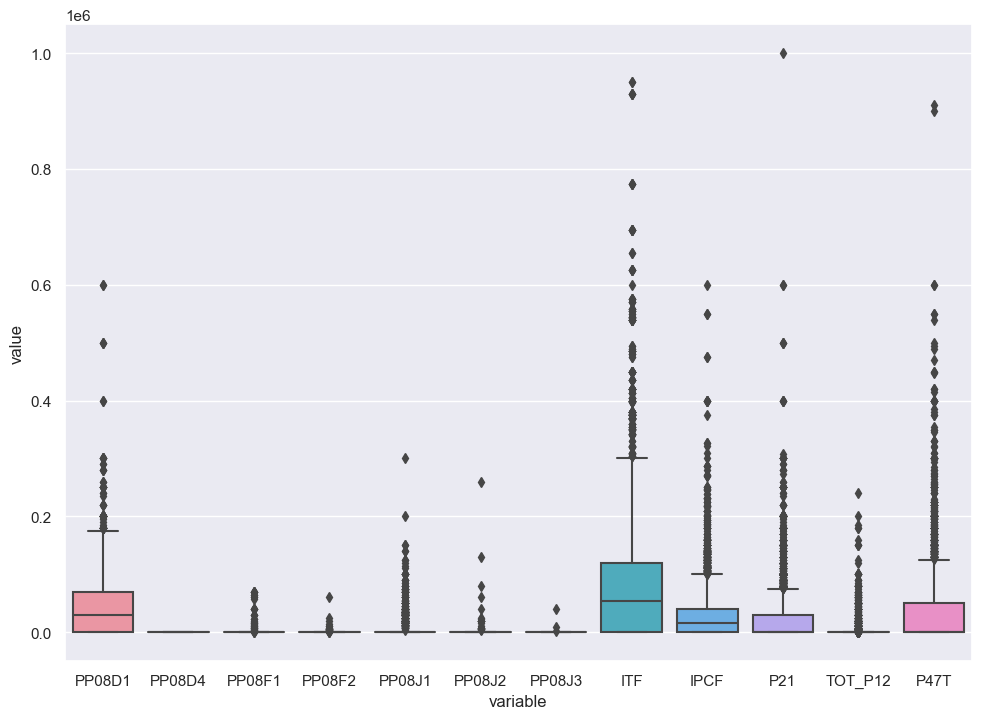

In [12]:
#Boxplots de variables que chequeamos outliers
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(eph[variables_para_outliers]))



In [13]:
#Generamos Interquantile Ranges, con eso sacamos los que queden afuera
#Asimetrico por ser ingreso una variable con lower bound pero no upper bound
Qlow = eph[variables_para_outliers].quantile(0)
Qhigh = eph[variables_para_outliers].quantile(0.90)
IQR = Qhigh - Qlow
print(IQR)
eph_inc = eph[variables_para_outliers]
eph_out = eph_inc[~((eph_inc < (Qlow - 1.5 * IQR)) |(eph_inc > (Qhigh + 1.5 * IQR))).any(axis=1)]
indexes = eph_out.index.values.tolist() 
eph=eph.loc[indexes]
print('No es sorpresa que sean 0 las que en graficos no tienen outliers faciles de observar a ojo. Notar que todas con outliers para arriba, no borramos los 0, mas en variables donde sean NO RESPONDE.')

PP08D1     110000.0
PP08D4          0.0
PP08F1          0.0
PP08F2          0.0
PP08J1      13000.0
PP08J2          0.0
PP08J3          0.0
ITF        203000.0
IPCF        70800.0
P21         80009.0
TOT_P12         9.0
P47T        95709.0
dtype: float64
No es sorpresa que sean 0 las que en graficos no tienen outliers faciles de observar a ojo. Notar que todas con outliers para arriba, no borramos los 0, mas en variables donde sean NO RESPONDE.


In [14]:
eph['ITF'].min()

0

In [15]:
#Chequeamos tipo de las variable restantes
eph.info(verbose=True)
print("Son todas object, int64 o float64, visto en una tabla:")
eph.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 0 to 6705
Data columns (total 198 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    NRO_HOGAR   int64  
 2    COMPONENTE  int64  
 3    H15         int64  
 4    CH03        int64  
 5    CH04        int64  
 6    CH05        object 
 7    CH06        int64  
 8    CH07        int64  
 9    CH08        int64  
 10   CH09        int64  
 11   CH10        int64  
 12   CH11        int64  
 13   CH12        int64  
 14   CH13        int64  
 15   CH14        float64
 16   CH15        int64  
 17   CH16        int64  
 18   NIVEL_ED    int64  
 19   ESTADO      int64  
 20   CAT_OCUP    int64  
 21   CAT_INAC    int64  
 22   PP02C1      int64  
 23   PP02C2      int64  
 24   PP02C3      int64  
 25   PP02C4      int64  
 26   PP02C5      int64  
 27   PP02C6      int64  
 28   PP02C7      int64  
 29   PP02C8      int64  
 30   PP02E       int64  
 31   PP02H       int64  
 32   PP

int64      126
float64     69
object       3
dtype: int64

In [17]:
#Definimos que variables no son categoricas
categoricas = ['CH03', 'CH04', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'NIVEL_ED',
               'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 
               'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A', 
               'PP04B1', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO',
               'PP05B2_DIA', 'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06E', 'PP06H', 'PP07A',
               'PP07C', 'PP07D', 'PP07E', 'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2', 'PP07G3', 
               'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K', 'PP09A', 'PP09B', 'PP09C', 'IV1', 'IV2', 'IV3', 
               'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II2', 'II3', 
               'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II5_1', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'V1', 'V2', 'V21', 
               'V22', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
               'V18', 'V19_A', 'V19_B', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2',
               'VII2_3', 'VII2_4']
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
no_borradas = pd.Index(categoricas).difference(eph.columns).tolist()
#las saco
categoricas = pd.Index(categoricas).difference(no_borradas).tolist()

In [18]:
#Las convertimos a categoricas
eph_d=eph.copy()
eph_d[categoricas] = eph_d[categoricas].astype('category')


In [19]:
#Reemplazamos NAs de categoricas por -1
for col in categoricas:
    eph_d[col]=eph_d[col].cat.add_categories(['-1'])
    eph_d[col]=eph_d[col].fillna('-1')


In [20]:
columnas_llenar_con_ceros = eph.columns[eph.isnull().any()]
eph[columnas_llenar_con_ceros]=eph[columnas_llenar_con_ceros].fillna(0)

PARA QUE ES eph_d ??????

4) Creamos 2 nuevas variables:
 _hab= cociente entre miembros del hogar y cantidad de habitaciones
 _niños= proporción de niños menores a 10 años en el hogar

In [22]:
#Definimos hab
eph["hab"]=eph["IX_TOT"]/eph["IV2"]

#Definimos niños
eph["niños"]=eph["IX_MEN10"]/eph["IX_TOT"]

6) Elegimos como relevantes las variabes para predecir pobreza varias de las mencionadas en el punto 1, sumado a 'NIVEL_ED', asumiendo que menor nivel educativo se relaciona con mayor probabilidad de ser pobre. Las demas justificaciones son las mismas que en el primer inciso.

In [24]:
#Estadisticas descriptivas 
listadeelegidas = ['NIVEL_ED','V5', 'II8', 'IX_MEN10', 'IV7' ]
summary = eph[listadeelegidas].describe(include='all')
print(summary)
        

          NIVEL_ED           V5          II8     IX_MEN10          IV7
count  5459.000000  5459.000000  5459.000000  5459.000000  5459.000000
mean      3.645539     1.783477     1.316725     0.573731     1.231361
std       1.788625     0.424184     0.572258     0.912945     0.434157
min       1.000000     1.000000     0.000000     0.000000     1.000000
25%       2.000000     2.000000     1.000000     0.000000     1.000000
50%       4.000000     2.000000     1.000000     0.000000     1.000000
75%       5.000000     2.000000     2.000000     1.000000     1.000000
max       7.000000     9.000000     4.000000     5.000000     4.000000


<span style='background :yellow' >  En general, cuando las variables son categóricas, en lugar de `describe()` se usa `value_counts`, porque lo que nos interesa en estas variables es la proporción en los distintos valores. Además, se esperaba que comenten un poco sobre las estadísticas, o almenos comenten los distintos valores que toman. Por ejemplo, qué significa que IV7 tenga básicamente todos los valores en 1?

7. Agregamos la columna adulto_equiv y adulto_equiv_hogar

In [29]:
df_equiv = pd.read_excel('tabla_adulto_equiv.xlsx')

df_equiv.loc[1,"Edad"]=1


for i in range(0,18):
    df_equiv.loc[i,"Edad"]= i 

for i in range(18,30): #18-29 años 0.76/1.02
    df_equiv.loc[i]= [i,0.76,1.02] 

for i in range(30,46): #30-45 años 0.77/1
    df_equiv.loc[i]= [i,0.77,1] 

for i in range(46,61): #46-60 años 0.76/1
    df_equiv.loc[i]= [i,0.76,1] 

for i in range(61,76): #61-75 años 0.67/0.83
    df_equiv.loc[i]= [i,0.67,0.83]

for i in range(76,106): #18-29 años 0.63/0.74. La edad max en la EPH es 105 años. 
    df_equiv.loc[i]= [i,0.63,0.74] 

df_equiv = df_equiv.rename(columns={'Edad':'CH06'})
print(df_equiv)

      CH06  Mujeres  Varones
0        0     0.35     0.35
1        1     0.37     0.37
2        2     0.46     0.46
3        3     0.51     0.51
4        4     0.55     0.55
5        5     0.60     0.60
6        6     0.64     0.64
7        7     0.66     0.66
8        8     0.68     0.68
9        9     0.69     0.69
10      10     0.70     0.79
11      11     0.72     0.82
12      12     0.74     0.85
13      13     0.76     0.90
14      14     0.76     0.96
15      15     0.77     1.00
16      16     0.77     1.03
17      17     0.77     1.04
18      18     0.76     1.02
19      19     0.76     1.02
20      20     0.76     1.02
21      21     0.76     1.02
22      22     0.76     1.02
23    23.0     0.76     1.02
24    24.0     0.76     1.02
25    25.0     0.76     1.02
26    26.0     0.76     1.02
27    27.0     0.76     1.02
28    28.0     0.76     1.02
29    29.0     0.76     1.02
30    30.0     0.77     1.00
31    31.0     0.77     1.00
32    32.0     0.77     1.00
33    33.0    

In [30]:
df_eph= eph.merge(df_equiv, on='CH06')

for i in range(len(df_eph)):
    if df_eph.loc[i,"CH04"]==1:
        df_eph.loc[i,"adulto_equiv"]=df_eph.loc[i,"Varones"]
    elif df_eph.loc[i,"CH04"]==2:
        df_eph.loc[i,"adulto_equiv"]=df_eph.loc[i,"Mujeres"]


df_eph.drop (["Varones","Mujeres"] , axis =1 , inplace = True)

In [31]:
df_sum=df_eph.groupby(['CODUSU', 'NRO_HOGAR'])[['adulto_equiv']].agg('sum')
df_sum.reset_index( inplace = True )
df_sum = df_sum.rename(columns={'adulto_equiv':'ad_equiv_hogar'})

df_eph=df_eph.merge(df_sum, on=["CODUSU", "NRO_HOGAR"])
df_eph=df_eph.sort_values(by="CODUSU")

#El data frame relevante ahora es df_eph


8. Dividimos la base en respondieron y no respondieron 

In [32]:
#Guardamos las obs que respondieron en el df 'df_respondieron':
df_respondieron = df_eph.drop(df_eph[df_eph['ITF']<=0].index)
df_respondieron.reset_index(inplace=True, drop=True)

##Guardamos las obs que no respondieron en el df 'df_norespondieron':
df_norespondieron= df_eph.drop(df_eph[df_eph['ITF']>0].index) 
df_norespondieron.reset_index( inplace = True )
print(len(df_norespondieron)) #chequeamos que la cantidad de obs sea igual a no_resp

2146


Agregamos la variable "ingreso_necesario"

In [33]:
df_respondieron["ingreso_necesario"]=df_respondieron["ad_equiv_hogar"]*(27197.64) #$27197.64 es la CBA


9. Agregamos la variable "pobre"

In [34]:
df_respondieron["Pobre"]=0

for i in range(len(df_respondieron)):
    if df_respondieron.loc[i,"ITF"] < df_respondieron.loc[i,"ingreso_necesario"] :
        df_respondieron.loc[i,"Pobre"]= 1

<span style='background :yellow' > Está bien, esto probablemente se vea mejor:

In [ ]:
import numpy as np

df_respondieron['Pobre'] = np.where(df_respondieron['ITF'] < df_respondieron['ingreso_necesario'], 1, 0)

10. Calculamos la tasa de hogares pobres para GBA, utilizando el ponderador PONDICH.


In [35]:
#Me quedo solo con GBA
df_respondieron_GBA =df_respondieron[df_respondieron['REGION']==1]

In [39]:
#Creamos base con solo una observacion por hogar
eph_hogares=df_respondieron_GBA.groupby(['CODUSU','NRO_HOGAR']).agg({"Pobre" : "mean","PONDIH" : "sum"})
#Sumamos cuanto hay de cada uno. 
sumas=eph_hogares.groupby("Pobre").PONDIH.sum().to_frame()
eph_porcentajes = sumas.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(eph_porcentajes)


          PONDIH
Pobre           
0.0    62.907318
1.0    37.092682


Notese que el porcentaje de pobres utilizando este metodo solo para REGION del GBA (distinto era si usabamos AGLOMERADO 33, partidos del GBA) es de 34.34%, mas de 4 p.p. por debajo del 39,2% reportado por INDEC considerando a nivel individual. 

## PARTE II

1) Definimos la función evalua_metodo. Qué toma como inputs las bases de train y test para X e Y y el modelo deseado (LogisticRegression, LinearDiscriminantAnalysis o KNeighborsClassifier) con su hiperparámetro. Y devuelve una colección de métricas del modelo que consiste en accuracy, auc y ecm.

In [44]:
def evalua_metodo(X_train, X_test, y_train, y_test, model, k=5, landa=1):
    '''    
    Toma como parametros las bases de train y test y el modelo deseado: LogisticRegression, LinearDiscriminantAnalysis,KNeighborsClassifier
    Devuelve las métricas: Accuracy, AUC y ECM.
    '''
    if model==KNeighborsClassifier:
        y = model(k).fit(X_train, y_train)
    elif model== LogisticRegression:
        y = model(C=1/landa).fit(X_train, y_train)
    elif model== LinearDiscriminantAnalysis:
        y = model().fit(X_train, y_train)
    else:
        y = model.fit(X_train, y_train)
    
    y_pred = y.predict(X_test)

    matriz_confusion = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, tresholds = roc_curve(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    ecm = mean_squared_error(y_test, y_pred)

    df_metrics = pd.DataFrame({'modelo': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm]})

    return df_metrics

<span style='background :yellow' > Me duele que digan "landa", es "lambda". Sé que lo hacen porque lambda es una función, pero ponganle hiperparámetro o algo (es una sugerencia, no los obligo ni nada)

2) Definimos la función cross_validation(model, k,x,y,standard=false) que toma como input el modelo desado (LogisticRegression, LinearDiscriminantAnalysis o KNeighborsClassifier),la cantidad de particiones 'k' para hacer CV, las bases X e Y y standard=True indica si se quiere estandarizar las variables para hacer CV. La función devuelve la media de los ECM de las k estimaciones realizadas por el método de cross-validation.

In [78]:
def cross_validation(model, k, x, y, standard=False):
    sc = StandardScaler()
    
    if standard==True:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            # Estandarizamos las observaciones de entrenamiento
            x_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
            # Estandarizamos las observaciones de test
            x_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

            ecm2 = evalua_metodo(x_train_transformed, x_test_transformed, y_train, y_test, model)
            ecm3 = ecm2['ecm'][0]
            ecm.append(ecm3)
        
        final_ecm = statistics.mean(ecm)

        return final_ecm
    
    elif standard==False:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model)
            ecm3 = ecm2['ecm']
            ecm.append(ecm3)

        final_ecm = statistics.mean(ecm)

        return final_ecm

<span style='background :yellow' > Fijense que lo que hacen en ambos condicionales es casi lo mismo excepto por dos lineas en el medio. En estos casos conviene hacer algo así en vez de lo que hicieron:

In [45]:
def cross_validation(model, k, x, y, standard=False):
    sc = StandardScaler()
    
    if standard==True:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
            
            if standard==True:
                # Estandarizamos las observaciones de entrenamiento
                x_train = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
                # Estandarizamos las observaciones de test
                x_test = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

            ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model)
            ecm3 = ecm2['ecm'][0]
            ecm.append(ecm3)
        
        final_ecm = statistics.mean(ecm)

        return final_ecm

3) Definimos la función evalua_config(landa, k, x, y, l_1ratio) que toma cómo inputs una collección de valores de lambdas (pueden ser una matriz o lista), el k de cross-validation, las bases X e Y y un valor para l1_ratio que debe estar entre 0 y 1 (1 indica que la función hace Lasso, 0 que hace Ridge, y cualquier valor intermedio hace Elastic Net ponderando en 'l1_ratio' a Lasso y '1-l1_ratio' a Ridge). Con esta información la función se encarga de calcular el lambda que minimiza el ECM por Cross-validation para la regresion logistica estimando por la elección de Lasso/Ridge/Elastic Net. Retorna el lambda óptimo y el valor del ECM para ese lambda.

In [46]:
def evalua_config (landa, k, x, y, l1_ratio=1):
    '''
    Toma cómo input una serie de valores de Lambda y el K para CV, y devuelve el lambda que minimiza el ECM por CV, usando elastic net para reg_logit
    l1_ratio=1 se hace Lasso
    l1_ratio=0 se hace Ridge
    0 <l1_ratio< 1 combinación de ambos en elastic net.  
    '''
    
    ret={}
    for elem in landa:
        clf_en_LR = LogisticRegression(
        C=1/elem, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01)
        ecm=cross_validation(clf_en_LR,k, x, y, standard=True)
        ret[elem]= ecm 

        
    return min(ret, key=ret.get)

4) Definimos la función evalua_metodos(k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y) que toma cómo inputs el k de Cross-Validation, el k de KNN, el valor máximo a testear de lambda para el modelo de regresión logistica, las bases de train y test de X e Y, y las bases completas de X e Y. La función se encarga de calcular los modelos KNN(con el k que le pasamos cómo input), Regresión logistica (con el lambda óptimo por Cross-Valdation) y Análisis Lineal de Discriminante y devuelve una tabla con las métricas correspondientes a cada modelo, entre las que se encuentran: hiperparámetro elegido, Accuracy, Auc y ECM.

In [47]:
def evalua_multiples_metodos (k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y): 
    
    modelos = ['regresion_logistica','k_vecinos_cercanos','analisis_discriminante']

    landas= np.arange(0.01, landa_max,10).tolist()

    matriz = pd.DataFrame(columns=["Modelo", "Hiperparametro","Precisión", "AUC", "ECM"])

    for modelo in modelos:
        if modelo == 'regresion_logistica':
            landa_optimo = evalua_config( landas, k_cv ,x, y) #hiperparametro landa
            metricas_log= evalua_metodo(x_train, x_test , y_train, y_test , LogisticRegression, landa=landa_optimo )
            results = [modelo, landa_optimo, metricas_log['accuracy'][0], metricas_log['auc'][0], metricas_log['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo =='k_vecinos_cercanos':
            metricas_kvc = evalua_metodo( x_train, x_test, y_train, y_test, KNeighborsClassifier, k=k_knn)
            results = [modelo, k_knn, metricas_kvc['accuracy'][0], metricas_kvc['auc'][0], metricas_kvc['ecm'][0]]
            matriz.loc[len(matriz)] = results
        
        elif modelo == 'analisis_discriminante':
            metricas_ad = evalua_metodo(x_train, x_test, y_train, y_test, LinearDiscriminantAnalysis)
            results = [modelo, "NA", metricas_ad['accuracy'][0], metricas_ad['auc'][0], metricas_ad['ecm'][0]]
            matriz.loc[len(matriz)] = results
        
    
    return(matriz)

<span style='background :yellow' > Está bien, está un poco demasiado hardcoded para cada modelo. En algun momento tienen que poner if's de acuerdo al modelo, pero se puede generalizar más que esto. Después van a tener que correr más modelos y van a tener un condicional para cada uno con mucho código repetido.

## PARTE III

1) Eliminamos todas variables de ingreso. Especificamos a que tipo de ingreso esta relacionada cada una. Dado que borramos algunas por tener demasiados NAs, borramos obviamente las no previamente decartadas, sacando la diferencia entre las variables definidas y las ya borradas. 

In [48]:
variables_ingreso = [
    "ITF","DECIFR","IDECIFR","RDECIFR","GDECIFR", "PDECIFR","ADECIFR", #Ingreso total familiar
    "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH", #Ingreso per capita familiar
    "PP06A", "PP06C", "PP06D", "PP06E", "PP06H", #Ingreso de las ocupaciones principales de independientes
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",#Ingreso de las ocupaciones principales de asalariados
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", #Ingreso de la ocupacion principal
    "TOT_P12", #Ingreso de otras ocupaciones
    "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII",#Ingreso total individual
    "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #Ingresos no laborales
    "adulto_equiv", "ad_equiv_hogar",  "ingreso_necesario"#Equivalentes e ingreso necesario
]
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
borradas = pd.Index(variables_ingreso).difference(df_norespondieron.columns).tolist()
#las saco
variables_ingreso_no_borradas = pd.Index(variables_ingreso).difference(borradas).tolist()

#Eliminamos
df_respondieron.drop(columns = variables_ingreso_no_borradas)
df_respondieron.drop(columns = ['ingreso_necesario']) #Esta solo en df_respondieron
df_norespondieron.drop(columns = variables_ingreso_no_borradas)

print(df_respondieron.head(10))
print(df_norespondieron.head(10))



                          CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  H15  \
0  TQRMNOPPQHJMNRCDEIJAH00693035  2022          1          1           4    0   
1  TQRMNOPPQHJMNRCDEIJAH00693035  2022          1          1           1    1   
2  TQRMNOPPQHJMNRCDEIJAH00693035  2022          1          1           3    0   
3  TQRMNOPPQHJMQLCDEIJAH00702455  2022          1          1           1    1   
4  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           4    0   
5  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           1    1   
6  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           3    1   
7  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           2    1   
8  TQRMNOPPQHKMQRCDEIJAH00780809  2022          1          1           3    1   
9  TQRMNOPPQHKMQRCDEIJAH00780809  2022          1          1           5    0   

   REGION MAS_500  AGLOMERADO  PONDERA  CH03  CH04                 CH05 CH06  \
0       1       S          3

Definimos y como la variable de si es pobre o no. X es el resto de variables, agregamos constante. 

In [49]:
y=df_respondieron['Pobre'] 
X=df_respondieron.loc[:, df_respondieron.columns != 'Pobre']
X['Constante']=1

2) Corremos la funcion evalua_multiples_metodos.

In [50]:
#Recordemos que tenemos 2 data base relevantes: df_respondieron y df_norespondieron
#Pasamos a float la variable MAS_500 que es de tipo String:
for i in range(len(df_respondieron)):
    if df_respondieron.loc[i,"MAS_500"] == "S" :
        df_respondieron.loc[i,"MAS_500"]= 1
    elif df_respondieron.loc[i,"MAS_500"] == "N":
        df_respondieron.loc[i,"MAS_500"]=0 

for i in range(len(df_norespondieron)):
    if df_norespondieron.loc[i,"MAS_500"] == "S" :
        df_norespondieron.loc[i,"MAS_500"]= 1
    elif df_norespondieron.loc[i,"MAS_500"] == "N":
        df_norespondieron.loc[i,"MAS_500"]=0

In [51]:
#Eliminamos CODUSU Y CH05, que son strings
df_norespondieron.drop (["CODUSU", "CH05"] , axis =1 , inplace = True)
df_respondieron.drop (["CODUSU", "CH05"] , axis =1 , inplace = True)

In [52]:
y=df_respondieron['Pobre'] 
X=df_respondieron.loc[:, df_respondieron.columns != 'Pobre']
X['Constante']=1

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
evalua_multiples_metodos (5,5, 30, X_train, X_test , y_train, y_test, X, y)

C:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Modelo,Hiperparametro,Precisión,AUC,ECM
0,regresion_logistica,10.01,0.997988,0.997735,0.002012
1,k_vecinos_cercanos,5.0,0.963783,0.962261,0.036217
2,analisis_discriminante,NA,0.949698,0.957754,0.050302


<span style='background :yellow' > No muestran el tipo de penalty utilizado (no podemos determinar si es mejor Lasso o Ridge). Es medio tonto dado que su función solo funciona para un penalty y evalua_config no permite cambiarlo. En realidad, el problema es que debería poder funcionar para chequear tanto Ridge y Lasso al mismo tiempo o el que uno quiera.

3) Se utiliza un metodo de K-Fold cross validation con la intencion de minimizar el error de prediccion por fuera de la muestra. Con varios $\lambda$ alternativos calculamos el error de pronostico partiendo los datos al azar en $K$ partes, ajustandolo dejando al azar afuera algunas de estas. Se elige el $\lambda$ con mejor predicciones. 

No se usan los datos de test ya que queremos comparar desempeño entre modelos, todos entrenados con la base de train. Como luego los compararemos en base al desempeño en test, no tiene sentido que lo elijamos con este mismo. 

<span style='background :yellow' > Es más que no tener sentido, usar la base de test para estimar el modelo es incorrecto porque lleva a overfit y probablemente un sesgo en las predicciones.

4) $K$ grande maximiza los datos utilizados para estimar, por lo que resulta sensible a los valores especificos, dependiendo el error de lo que pase con pocos datos de test.

$K$ chico maximiza los datos para utilizados para evaluar, el modelo estimado resulta menos preciso por ello.

$K=n$ resulta ser leave one out, estimandolo n veces con $n-1$ datos. 

5) 

In [80]:
# Ridge y Lasso
lambdas=10**np.linspace(-5,5,11)
landa_optimo_lasso = evalua_config(lambdas, 10, X, y, l1_ratio=1) #Lasso
landa_optimo_ridge = evalua_config(lambdas, 10, X, y, l1_ratio=0) #Ridge

In [81]:
print(landa_optimo_ridge)
print(landa_optimo_lasso)

0.001
10.0


In [82]:
print(f'El λ elegido con Ridge es {landa_optimo_ridge} y Lasso es {landa_optimo_lasso}.')

El λ elegido con Ridge es 0.001 y Lasso es 10.0.


In [83]:
def cross_validation2(model, k, x, y, standard=False):
    sc = StandardScaler()
    
    if standard==True:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            # Estandarizamos las observaciones de entrenamiento
            x_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
            # Estandarizamos las observaciones de test
            x_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

            ecm2 = evalua_metodo(x_train_transformed, x_test_transformed, y_train, y_test, model)
            ecm3 = ecm2['ecm'][0]
            ecm.append(ecm3)
        
        final_ecm = statistics.mean(ecm)

        return final_ecm
    
    elif standard==False:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model)
            ecm3 = ecm2['ecm']
            ecm.append(ecm3)

        final_ecm = ecm

        return final_ecm
#Armamos para que nos devuelva todos
def evalua_config2 (landa, k, x, y, l1_ratio=1):
    '''
    Toma cómo input una serie de valores de Lambda y el K para CV, y devuelve el lambda que minimiza el ECM por CV, usando elastic net para reg_logit
    l1_ratio=1 se hace Lasso
    l1_ratio=0 se hace Ridge
    0 <l1_ratio< 1 combinación de ambos en elastic net.  
    '''
    
    ret=pd.DataFrame(columns=[ "ecm", "parámetro"])
    for i in range(len(landa)):
        clf_en_LR = LogisticRegression(
        C=1/landa[i], penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01)
        ecm=cross_validation2(clf_en_LR,k, x, y, standard=True)
        ret.loc[i]= [ecm,landa[i]]
        
    return ret

#Corremos
lassos = evalua_config2(lambdas, 10, X, y, l1_ratio=1) #Lasso
ridges = evalua_config2(lambdas, 10, X, y, l1_ratio=0) #Ridge

<span style='background :yellow' > No es ideal ir creando nuevas funciones en base a los puntos, la idea es que las funciones originales permitan hacer estas cosas.

In [84]:
print(ridges)

         ecm     parámetro
0   0.035308       0.00001
1   0.034704       0.00010
2   0.034403       0.00100
3   0.033810       0.01000
4   0.031994       0.10000
5   0.034407       1.00000
6   0.037426      10.00000
7   0.040735     100.00000
8   0.060054    1000.00000
9   0.131024   10000.00000
10  0.326589  100000.00000


C:\Users\Matias\AppData\Local\Temp\ipykernel_24364\920968289.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])


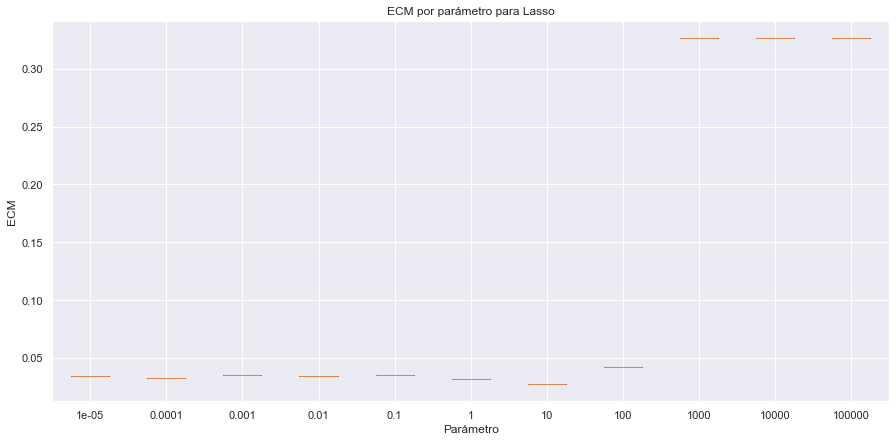

In [85]:
# Creamos las variables en las cuales almaceno su ecm por parámetro, para las diferentes particiones
for i, x in zip(lambdas, range(1,12,1)):
     locals()["l_"+str(x)] = lassos[lassos["parámetro"]==i].ecm
for i, x in zip(lambdas, range(1,12,1)):
     locals()["r_"+str(x)] = ridges[ridges["parámetro"]==i].ecm
        
# Definimos una variable con todas las variables con los ecm por parámetro para hacer el boxplot
data_l = (l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11)
data_r = (r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,r_10,r_11)

# Boxplot para Lasso
fig, ax = plt.subplots(figsize =(15, 7))
ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])
ax.set(title="ECM por parámetro para Lasso" , ylabel= "ECM", xlabel= "Parámetro")
ax.boxplot(data_l)
plt.show()

C:\Users\Matias\AppData\Local\Temp\ipykernel_24364\3743415611.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])


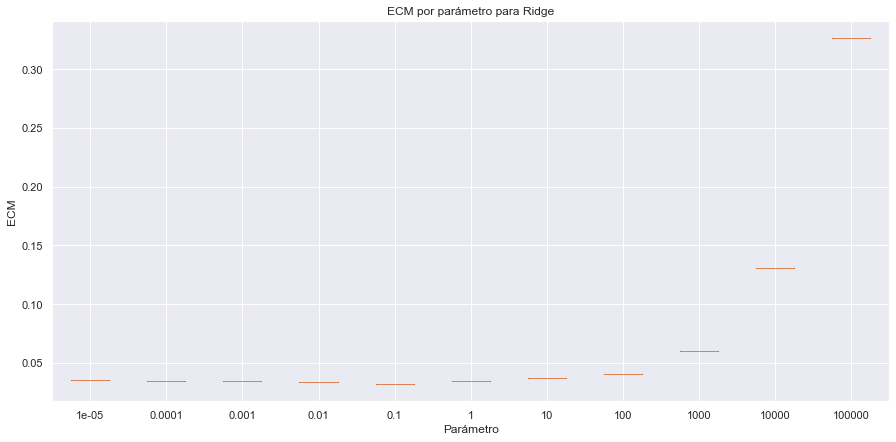

In [86]:
# Boxplot para Ridge
fig, ax = plt.subplots(figsize =(15, 7))
ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])
ax.set(title="ECM por parámetro para Ridge" , ylabel= "ECM", xlabel= "Parámetro")
ax.boxplot(data_r)
plt.show()

<span style='background :yellow' > No responden proporción de variables eliminadas por LASSO ni punto 6.

7) Comparamos para el caso donde $\lambda=0.2$.

In [87]:
r=ridges.ecm[4]
l=lassos.ecm[4]
print(f'De elegir landa igual a 0.1, el ECM de Lasso es {l} y de Ridge {r}. Siendo el menor {min(l,r)}, de Lasso.')

De elegir landa igual a 0.1, el ECM de Lasso es 0.03531831252502457 y de Ridge 0.03199413970079715. Siendo el menor 0.03199413970079715, de Lasso.


<span style='background :yellow' > No es lo que se pide. Tenían que decir, para toda una lista de hiperparámetros, cuál modelo minimizaba el ECM.

8) Buscamos cual predice mejor. 

In [88]:
m=evalua_multiples_metodos (5,5, 20, X_train, X_test , y_train, y_test, X, y)


C:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
print(f'El modelo que mejor anda es {m.loc[m["ECM"] == min(m["ECM"])]["Modelo"][0]}, con ECM de {min(m["ECM"])}.')


El modelo que mejor anda es regresion_logistica, con ECM de 0.002012072434607646.


9) Predecimos pobres entre los que no respondieron.

In [90]:
df_norespondieron['Constante']=1
lambdas=np.arange(0.01, 10000,1000).tolist()
landa_optimo_en = evalua_config(lambdas, 10, X, y, l1_ratio=0.5) 
logi=LogisticRegression(
        C=1/landa_optimo_en, penalty="elasticnet", solver="saga", l1_ratio=0.5, tol=0.01).fit(X_train,y_train)
pobres_no_respondieron=logi.predict(df_norespondieron)


C:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- index
Feature names seen at fit time, yet now missing:
- ingreso_necesario

  warnings.warn(message, FutureWarning)


In [91]:
pobres_nr=np.sum(pobres_no_respondieron)
tasa_pobreza_nr=np.sum(pobres_no_respondieron)/len(pobres_no_respondieron)
print(f'Entre los que no respondieron hay {pobres_nr}, siendo de una proporcion {tasa_pobreza_nr}.')

Entre los que no respondieron hay 1075, siendo de una proporcion 0.5009319664492078.


<span style='background :yellow' > Les da bastante alto, no? Por qué cambiaron el modelo a elasticnet si el elegido fue regresión logística, que en su función corre con penalty l1 por default? También pusieron una lista de hiperparámetros distinta...